In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gpflow
import tensorflow.compat.v1 as tf
from sklearn.metrics import r2_score
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import ParameterGrid
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import seaborn as sns

tf.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

#models
#---------------------------------------------------------------
#---------------------------------------------------------------
def moving_average(data, window_size, n_forecast):
    return data.rolling(window = window_size).mean().iloc[-n_forecast:]

#---------------------------------------------------------------
def autoregression(data, start, end):
    res = AutoReg(data, lags = 1).fit()
    return res.model.predict(res.params, start = start, end = end)

#---------------------------------------------------------------
def simple_exponential_smoothing(data, n_forecast):
    model = SimpleExpSmoothing(data)
    model_fit = model.fit()
    return model_fit.forecast(n_forecast)

#---------------------------------------------------------------
def holtWinter_smoothing(data, n_forecast):
    model = ExponentialSmoothing(data)
    model_fit = model.fit()
    return model_fit.forecast(n_forecast)

#---------------------------------------------------------------
def arima_model(data, n_forecast):
    model = ARIMA(endog = data)
    model_fit = model.fit()
    return model_fit.forecast(steps = n_forecast)

#---------------------------------------------------------------
def linear_regression_model(Xtrain, ytrain, Xtest):
    
    model = LinearRegression()
    model.fit(Xtrain, ytrain)
    return model.predict(Xtest)

#---------------------------------------------------------------
def GPR(Xtrain, ytrain, Xtest):


    kernel = gpflow.kernels.RBF(lengthscales = 10)

    model = gpflow.models.SGPR(data = (Xtrain, ytrain), 
                               kernel = kernel, 
                               inducing_variable = Xtrain[::10])

    #opt = gpflow.optimizers.Scipy()
    opt = tf.optimizers.Adam()
    opt_logs = opt.minimize(model.training_loss, 
                            model.trainable_variables, 
                            options = dict(maxiter = 100))
    predictions, _ = model.predict_y(Xtest)
    return predictions

#---------------------------------------------------------------


In [21]:

df = pd.read_csv("52.75_Vandstand_Minut.csv", 
                        delimiter = ";", 
                        skiprows = 12,
                        encoding = "unicode-escape")

df=df.drop(columns=['ks mrk.'])
df=df.rename(columns={"Dato (DK normaltid)":"time", "Vandstand (m DVR90)":"level"})
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y %H:%M')

df.set_index('time', inplace=True)
df.head()

,level
time,
2014-06-20 00:00:00,11.421
2014-06-20 00:15:00,11.421
2014-06-20 00:30:00,11.422
2014-06-20 00:45:00,11.422
2014-06-20 01:00:00,11.422


<Axes: title={'center': 'Water level Sengeløse '}, xlabel='time'>

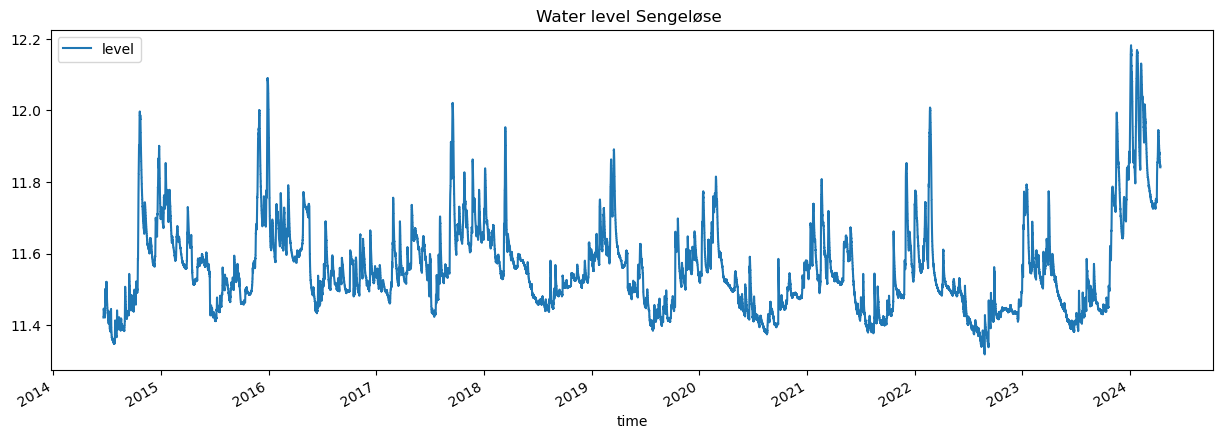

In [22]:
df.plot( figsize=(15, 5), title="Water level Sengeløse ")

In [23]:
#feature creation ideas

def create_features(df):
    
    df = df.copy()
    #df['hour'] = df.index.hour
    #df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    #df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    #df['quarter'] = df.index.quarter
    #df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week 
    return df

df = create_features(df)
df['time_numeric'] = (df.index - df.index.min()) / pd.Timedelta(minutes=15)


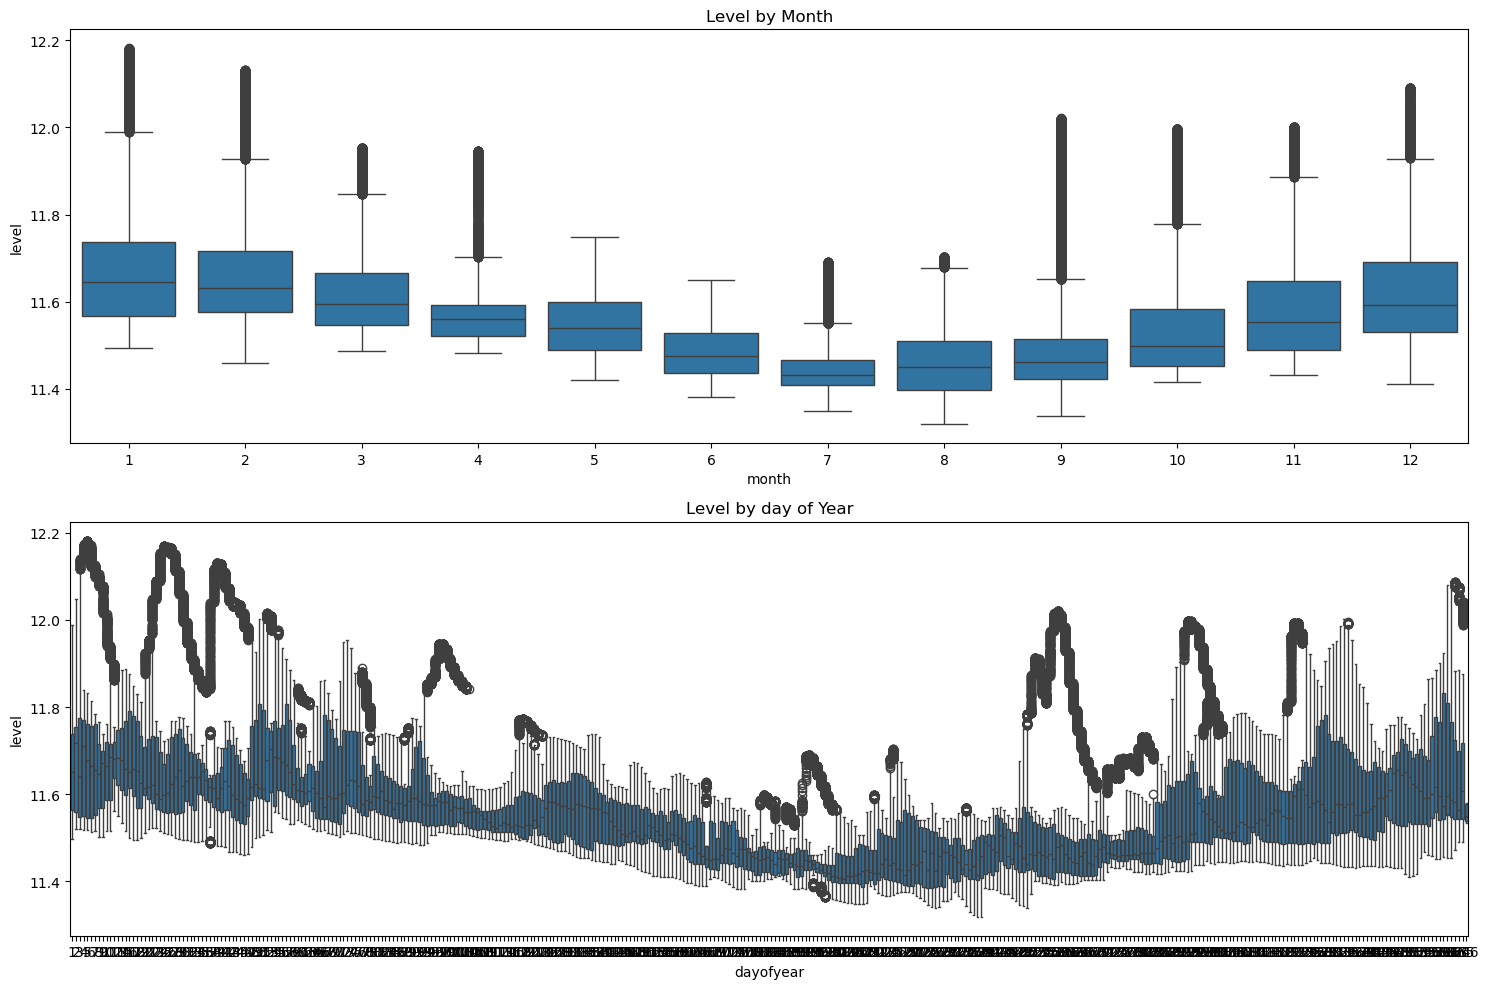

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

sns.boxplot(data=df, x='month', y='level', ax=axs[0])
axs[0].set_title('Level by Month')

sns.boxplot(data=df, x='dayofyear', y='level', ax=axs[1])
axs[1].set_title('Level by day of Year')

plt.tight_layout()
plt.show()

In [25]:
# lag creation 

def add_lags(df):
    target_map = df['level'].to_dict()

    # Add hourly lags
    #for hours in [1, 4, 8, 16, 24]:
    #    df[f'lag_{hours}h'] = (df.index - pd.Timedelta(hours, unit='h')).map(target_map)

    # Add daily lags for the last 7 .. 31days
    for days in range(7, 31):
        df[f'lag_{days}d'] = (df.index - pd.Timedelta(days, unit='d')).map(target_map)
    df=df.bfill()

    return df

#df = add_lags(df)


In [26]:
#split function 

def split(n_splits=10,test_size=4 * 24 * 7, df=df):
    total_length = len(df)
    interval_length = (total_length // n_splits) - test_size

    for i in range(n_splits):
        end_train = i * (interval_length + test_size) + interval_length
        start_test = end_train
        end_test = start_test + test_size

        if end_test > total_length:  # Ensure the test data is within bounds
            break

        train_idx = np.arange(0, end_train)
        test_idx = np.arange(start_test, end_test)

        yield train_idx, test_idx
    

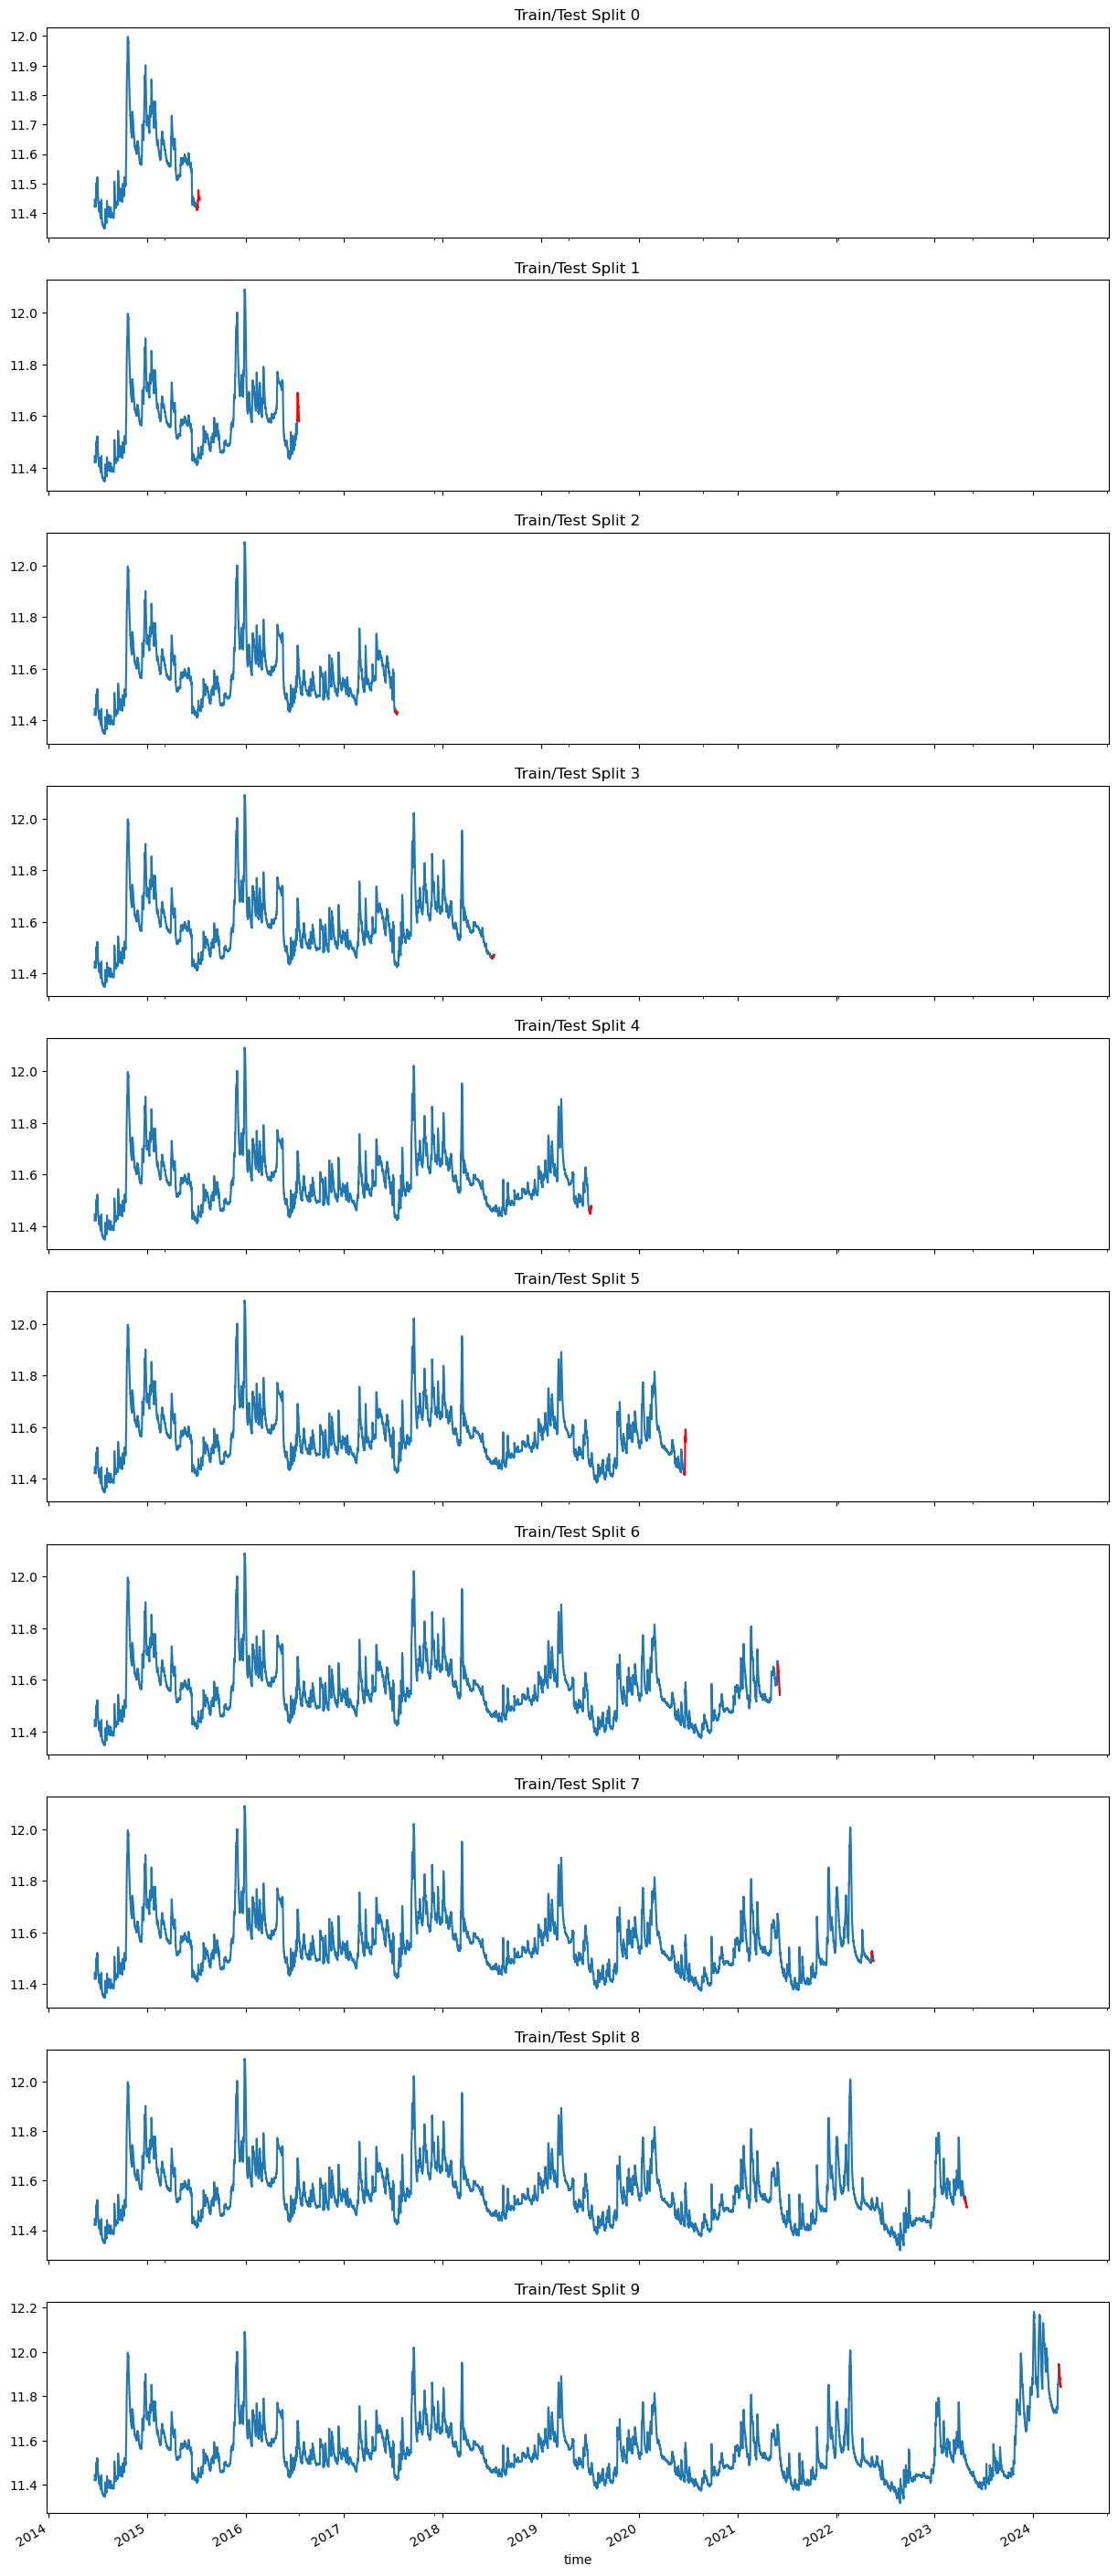

In [27]:
n_splits = 10
test_size=4 * 24 * 7

# Plotting
fig, axs = plt.subplots(n_splits, 1, figsize=(15, n_splits * 4), sharex=True)

# Use the custom time series split function
for fold, (train_idx, test_idx) in enumerate(split(n_splits)):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]

    train["level"].plot(ax=axs[fold], title=f"Train/Test Split {fold}")
    test["level"].plot(ax=axs[fold], color='red')

plt.show()

In [ ]:
def runxgb(model, df, features):
    r2_scores = []
    predictions_list = []
    
    for train_idx, test_idx in split(df=df):
        X_train = df.iloc[train_idx][features]
        y_train = df.iloc[train_idx][ 'level']
        X_test = df.iloc[test_idx][features]
        y_test = df.iloc[test_idx][ 'level']
        
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)
        predictions = model.predict(X_test)
        r2 = r2_score(y_test, predictions)
        r2_scores.append(r2)
        predictions_list.append(predictions)
        
        print(f"R2 for this split: {r2}")
    
    mean_r2 = np.mean(r2_scores)
    print(f"Mean R2 across all splits: {mean_r2}")
    
    return predictions_list, r2_scores

In [28]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=FutureWarning, module="statsmodels")

In [29]:


# Initialize feature selection variables
X = df.drop('level', axis=1)  # Assuming 'level' is the target
y = df['level']
all_features = X.columns.tolist()
selected_features = []
remaining_features = all_features.copy()
best_score = float('-inf')

# Forward feature selection process
while remaining_features:
    scores = {}
    for feature in remaining_features:
        current_features = selected_features + [feature]
        current_score =[]
        for train_idx, test_idx in split(10):
            X_train, X_test = X.iloc[train_idx][current_features], X.iloc[test_idx][current_features]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=500,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=5,
                           min_child_weight=3,
                           learning_rate=0.1)            
            model.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=0)     
            y_pred = model.predict(X_test)
            current_score.append(r2_score(y_test, y_pred))
        mean_r2 = np.mean(current_score)  # Assuming 5 splits
        scores[feature] = mean_r2
        print(f"Tested {feature}: Mean R² = {mean_r2}")

    best_feature, best_feature_score = max(scores.items(), key=lambda x: x[1])
    if best_feature_score > best_score:
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        best_score = best_feature_score
        print(f"Selected {best_feature} with improvement to R² = {best_feature_score}")
    else:
        print("No further improvement, stopping selection.")
        break
df = df[selected_features + ['level']]
print("Selected features:", selected_features)

Tested month: Mean R² = -8.755346025072502
Tested dayofyear: Mean R² = -9.529524996682778
Tested weekofyear: Mean R² = -9.228876098070964
Tested time_numeric: Mean R² = -1.6381083071031208
Selected time_numeric with improvement to R² = -1.6381083071031208
Tested month: Mean R² = -0.9973488012156422
Tested dayofyear: Mean R² = -0.7341933936475373
Tested weekofyear: Mean R² = -0.9796977822918245
Selected dayofyear with improvement to R² = -0.7341933936475373
Tested month: Mean R² = -0.7417337052371404
Tested weekofyear: Mean R² = -0.8072187762461307
No further improvement, stopping selection.
Selected features: ['time_numeric', 'dayofyear']


-0.1

In [31]:

# Setup parameter grids
group1_params = {
    'max_depth': [ 5, 7, 9, 11],
    'min_child_weight': [ 3, 5, 7, 9]
}
group2_params = {
    'subsample': [0.6, 0.8, 1.0, ],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
group3_params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 500, 1000, 2000]
}

# Default parameters, updated based on tuning
best_params = {
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'n_estimators': 500
}

# Function to tune parameters using R-squared
def tune_parameters(params_grid, fixed_params):
    results = {}
    for params in ParameterGrid(params_grid):
        current_params = fixed_params.copy()
        current_params.update(params)
        r2_scores = []
        for train_idx, test_idx in split(10):
            trainData, testData = df.iloc[train_idx], df.iloc[test_idx]
            X_train, X_test = trainData.drop('level', axis=1), testData.drop('level', axis=1)
            Y_train, Y_test = trainData['level'], testData['level']
            model = xgb.XGBRegressor(**current_params, objective='reg:squarederror', early_stopping_rounds=50)
            model.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], verbose=False)
            predictions = model.predict(X_test)
            r2 = r2_score(Y_test, predictions)
            r2_scores.append(r2)
        results[str(params)] = np.mean(r2_scores)
    best_params = max(results, key=results.get)  # Maximize R²
    return best_params, results[best_params]

# Perform tuning for each parameter group
best_group1_params, best_group1_r2 = tune_parameters(group1_params, best_params)
best_params.update(eval(best_group1_params))
print("Best Group 1 Params:", best_group1_params, "R²:", best_group1_r2)

best_group2_params, best_group2_r2 = tune_parameters(group2_params, best_params)
best_params.update(eval(best_group2_params))
print("Best Group 2 Params:", best_group2_params, "R²:", best_group2_r2)

best_group3_params, best_group3_r2 = tune_parameters(group3_params, best_params)
best_params.update(eval(best_group3_params))
print("Best Group 3 Params:", best_group3_params, "R²:", best_group3_r2)


KeyboardInterrupt: 

Best Group 1 Params: {'max_depth': 5, 'min_child_weight': 3} R²: -1.6368060212174034
Best Group 2 Params: {'colsample_bytree': 0.8, 'subsample': 0.6} R²: -1.5846983156952636
Best Group 3 Params: {'learning_rate': 0.01, 'n_estimators': 1000} R²: -1.1999629875565228


In [ ]:


# Custom split function as provide
mavg_windows = [1,2, 10,100, 1000, 100000]  # Example window sizes
mavg_results = {window: [] for window in mavg_windows}

# Training and validation loop
for train_idx, test_idx in split(100):
    trainData, testData = df.iloc[train_idx], df.iloc[test_idx]
    X_train, X_test = trainData.drop('level', axis=1), testData.drop('level', axis=1)
    Y_train, Y_test = trainData['level'], testData['level']

    # Moving average tuning
    for window in mavg_windows:
        forecast = trainData['level'].rolling(window=window).mean().iloc[-len(testData):]
        if len(forecast.dropna()) == len(Y_test):
            mse = r2_score(Y_test, forecast.dropna())
            mavg_results[window].append(mse)  # Append mse to the list for each window
            print(f"Window: {window}, MSE: {mse}")

# Calculate mean MSE for each window size and find the best one
mavg_avg_results = {window: np.mean(scores) if scores else np.nan for window, scores in mavg_results.items()}
best_mavg_window = max(mavg_avg_results, key=mavg_avg_results.get)
print("Best Moving Average window size:", best_mavg_window)
print("Best Moving Average MSE:", mavg_avg_results[best_mavg_window])

Window: 1, MSE: -121.29960022783992
Window: 2, MSE: -121.37685144857443
Window: 10, MSE: -122.00187685139348
Window: 100, MSE: -127.31441355114569
Window: 1000, MSE: -166.40361081079146
Window: 1, MSE: -15.220678792656422
Window: 2, MSE: -15.224036167272338
Window: 10, MSE: -15.333972362844786
Window: 100, MSE: -14.865927250269923
Window: 1000, MSE: -7.347178013660267
Window: 1, MSE: -1.4231023887189767
Window: 2, MSE: -1.4200437882519665
Window: 10, MSE: -1.3958059252581476
Window: 100, MSE: -1.0194859009413282
Window: 1000, MSE: -1.4320749894367655
Window: 1, MSE: -48.369994832494235
Window: 2, MSE: -48.47623271590744
Window: 10, MSE: -49.32962773862961
Window: 100, MSE: -58.856156598976405
Window: 1000, MSE: -71.25053330926723
Window: 1, MSE: -161.90249445616791
Window: 2, MSE: -162.19823162603504
Window: 10, MSE: -164.58493224561107
Window: 100, MSE: -190.8791075835049
Window: 1000, MSE: -203.95993446794262
Window: 1, MSE: -0.45658746584068766
Window: 2, MSE: -0.45299542761128864
W

In [ ]:


r2_scores_mean = {}
predictions = {}

models = ["mavg", "xgb"] #"areg", "simple", "exp", "arima","linreg", "gbr" "linreg",
#df['time_numeric'] = (df.index - df.index.min()) / pd.Timedelta(minutes=15)

for model in models:
    print("Model =", model)
    r2s = []
    
    last_forecast = None
    
    for train_idx, val_idx in split(15):
        trainData = df.iloc[train_idx]
        testData = df.iloc[val_idx]
        
        ntest = testData.shape[0]
        Ytest = testData["level"].values

        if model in ["mavg", "areg", "simple", "exp", "arima"]:
            trainData = trainData["level"]  
            testData = testData["level"]
        else:

            Xtrain = trainData.drop(columns = "level")
        
            Ytrain = trainData["level"].values 
            Xtest = testData.drop(columns = "level")  

        if model == "mavg":
            forecast = moving_average(trainData, 100, ntest)
        elif model == "areg":
            forecast = autoregression(trainData, start=len(trainData), end=len(trainData) + ntest - 1)
        elif model == "simple":
            forecast = simple_exponential_smoothing(trainData, ntest)
        elif model == "exp":
            forecast = holtWinter_smoothing(trainData, ntest)
        elif model == "arima":
            forecast = arima_model(trainData, n_forecast=ntest)
        elif model == "linreg":
            forecast = linear_regression_model(Xtrain, Ytrain, Xtest)
        elif model == "gpr":
            forecast = GPR(Xtrain, Ytrain, Xtest)
        elif model == "xgb":
            reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=5,
                           min_child_weight=3,
                           learning_rate=0.1,
                           colsample_bytree=1,
                           subsample=0.6
                           )
            reg.fit(Xtrain, Ytrain,
                eval_set=[(Xtrain, Ytrain), (Xtest, Ytest)],
                verbose=0)        
            r2, forecast = reg.predict(Xtest)

        r2 = r2_score(Ytest, forecast)
        r2s.append(r2)

        last_forecast = forecast
        
        print("R2 =", r2)

    r2_scores_mean[model] = np.mean(r2s)
    print("meanR2 =", r2_scores_mean[model])
    
    predictions[model] = {
        
        "forecast": last_forecast
    }


Model = mavg
R2 = -1.8483013791413017
R2 = -1.1940065977086753
R2 = -9.517701737263122
R2 = -0.9589122226849254
R2 = -4.808587816934422
R2 = -2.081773623609447
R2 = -5.311539875596146
R2 = -18.132312160590036
R2 = -0.7202476885900506
R2 = -68.46103153706706
R2 = -0.3244045393082784
R2 = -2.803485141499094
R2 = -2.351989158071371
R2 = -1.444713957614065
R2 = -11.148040410216359
meanR2 = -8.740469856392957
Model = xgb
R2 = -0.0009272521384673382
R2 = -0.9008829531996405
R2 = -4.713157769459432
R2 = -0.13558659271715467
R2 = -0.12217907728347255
R2 = -0.2978391005428047
R2 = -5.0101010587968995
R2 = -0.005951170174933962
R2 = -0.6750303736547549
R2 = -0.12898925196284305
R2 = 0.11984079282383808
R2 = 0.2557972858450335
R2 = -0.10452445317165893
R2 = -1.674068657275818e-05
R2 = 0.09643719253782568
meanR2 = -0.7748740348387956


In [ ]:
-3

-3

time
2024-03-16 23:30:00    11.742
2024-03-16 23:45:00    11.742
2024-03-17 00:00:00    11.742
2024-03-17 00:15:00    11.742
2024-03-17 00:30:00    11.742
                        ...  
2024-04-06 22:15:00    11.944
2024-04-06 22:30:00    11.944
2024-04-06 22:45:00    11.944
2024-04-06 23:00:00    11.944
2024-04-06 23:15:00    11.945
Name: level, Length: 2016, dtype: float64


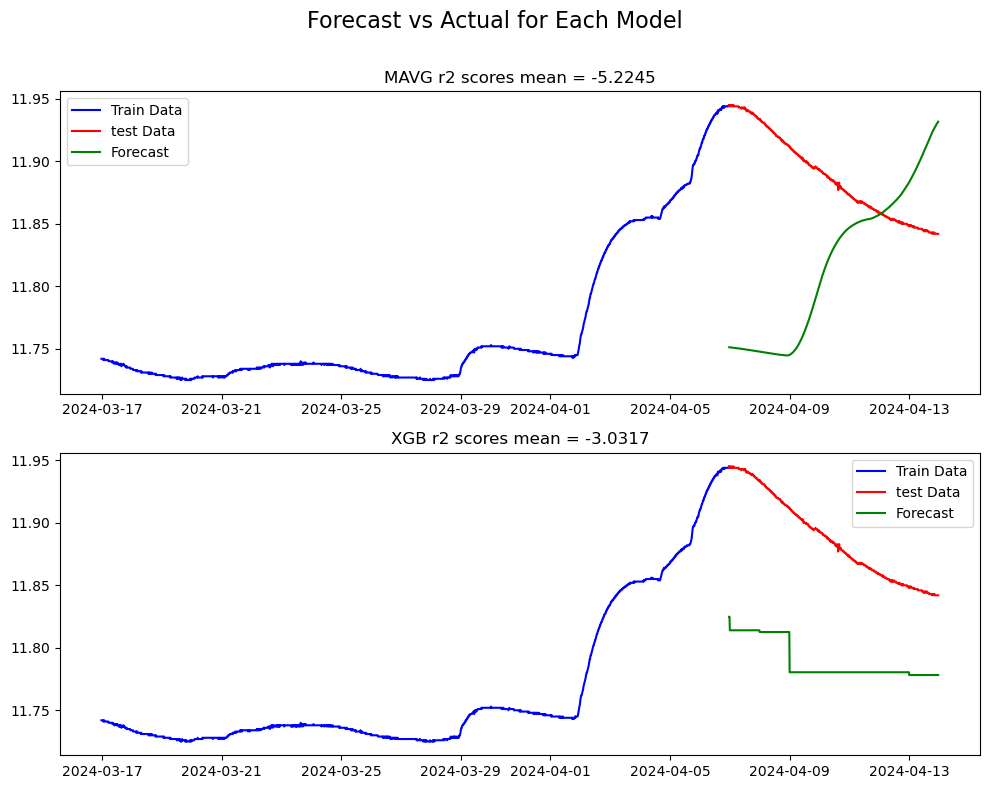

In [ ]:
fig, axs = plt.subplots(len(models), 1, figsize=(10, len(models) * 4))
fig.suptitle('Forecast vs Actual for Each Model', fontsize=16)
print(trainData["level"][-3*test_size:])
for i, model in enumerate(models):
    ax = axs[i]
    ax.plot(trainData["level"][-3*test_size:],  label="Train Data", color="blue")
    ax.plot(testData["level"], label="test Data", color="red")
    ax.plot(testData["level"].index, predictions[model]["forecast"], label="Forecast", color="green")
    
    ax.set_title(f"{model.upper() } r2 scores mean = {r2_scores_mean[model].round(4)}")
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()